In [2]:
import os, sys

import sgpp, sgml, dproc, sgutil
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print(sys.version)

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

3.12.6 (main, Sep 30 2024, 02:19:13) [GCC 9.4.0]


**Idea**
- 선형회귀 모델의 예측값을 cross-fitting을 하여 만들어냅니다.
- 이 때에 Episode_Length_minutes을 빼고 전체 데이터셋으로 만들고, 다른 하나는 Episode_Length_minutes 포함하여 미결측인 것에 대해 만듭니다.
- 잔차를 구하고, 잔차를 예측하는 GBM 모델들을 수치형 변수는 모두 범주형 변수로 취급한 상태로 만들어 냅니다.
- 수치형 변수를 범주형 변수로 만들 때에는 최소 등장 빈도 이상인 것에 대해서 범주화를 합니다. 
- 최적의 등장 빈도는 실험을 통해서 탐색해봅니다.

In [3]:
sc = sgutil.SGCache('img', 'result', 'model')
p = make_pipeline(
    sgpp.PolarsProcessor(),
    sgpp.ExprProcessor({
        'ELm_num': (pl.col('Episode_Length_minutes').clip(5, 120) - 5) / 115,
        'GP': (pl.col('Guest_Popularity_percentage').fill_null(pl.col('Guest_Popularity_percentage').clip(0,100).mean()).clip(0, 100) / 100),
        'HP': pl.col('Host_Popularity_percentage').clip(0, 100) / 100,
        'NAd': (pl.when(pl.col('Number_of_Ads') > 4).then(0).otherwise(pl.col('Number_of_Ads'))).fill_null(0.0) /3 ,
        'Number_of_Ads': (pl.when(pl.col('Number_of_Ads') > 4).then(0).otherwise(pl.col('Number_of_Ads'))).fill_null(0).cast(pl.Int8),
        'ELm_na': pl.col('Episode_Length_minutes').is_null(),
        'GPp_na': pl.col('Guest_Popularity_percentage').is_null(),
        'ELm_sqrt': ((pl.col('Episode_Length_minutes').clip(5, 120) - 5) / 115)  ** 0.5
    }),
    sgpp.PandasConverter(index_col = 'id')
)
p.fit(['data/train.csv'])

Pipeline(steps=[('polarsprocessor',
                 <sgpp.PolarsProcessor object at 0x7f71526ffbf0>),
                ('exprprocessor',
                 <sgpp.ExprProcessor object at 0x7f71526ffce0>),
                ('pandasconverter',
                 <sgpp.PandasConverter object at 0x7f71526fcd10>)])

In [4]:
df_train = p.transform(['data/train.csv'])
df_train_1 = df_train.loc[df_train['Episode_Length_minutes'].notna()]
target = 'Listening_Time_minutes'
resi = 'resi'
X_all = [i for i in df_train.columns if i != target]

In [5]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold, cross_validate, cross_val_score, ShuffleSplit
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector
kf = KFold(4, shuffle = True, random_state = 123)
ss = ShuffleSplit(1, train_size = 0.75, random_state = 123)

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction)

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index = df.index),
    'score_func': lambda df, prds: root_mean_squared_error(df[target], prds),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'y': target,
}

config2 = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index = df.index),
    'score_func': lambda df, prds: root_mean_squared_error(df[resi], prds),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'y': resi,
}

lr_adapter = sgml.SklearnAdapter(LinearRegression)
lgb_adapter = sgml.LGBMAdapter(lgb.LGBMRegressor, progress = 50)

In [6]:
from itertools import combinations
from tqdm.notebook import tqdm 
from cuml.preprocessing import TargetEncoder

def get_tgt_rmse(df, X_tgt, smooth_space = np.linspace(1, 10, 10)):
    rmse_fold = list()
    best_prd = None
    best_rmse = np.inf
    for i in smooth_space:
        tgt = TargetEncoder(smooth = i, split_method ='continuous')
        prds = list()
        rmses = list()
        for train_idx, test_idx in kf.split(df[X_tgt], df[resi]):
            df.iloc[train_idx].pipe(lambda x: tgt.fit(x[X_tgt], x[resi]))
            df_valid = df.iloc[test_idx]
            prds.append(
                pd.Series(tgt.transform(df_valid[X_tgt]), index = df_valid.index)
            )
            rmses.append(
                root_mean_squared_error(df_valid[resi], prds[-1])
            )
        rmse_fold.append(np.mean(rmses))
        if best_rmse > rmse_fold[-1]:
            best_rmse = rmse_fold[-1]
            best_prd = pd.concat(prds)
    return np.min(rmse_fold), smooth_space[np.argmin(rmse_fold)], best_prd

def get_tgt_rmse_list(df, X_values, smooth_space = [0.01, 0.1, 1, 10, 100, 1000]):
    results = list()
    best_prd_list = list()
    for i in tqdm(X_values):
        rmse, best_smooth, best_prd = get_tgt_rmse(df, i, smooth_space = smooth_space)
        results.append(
            pd.Series(
                [i, rmse, best_smooth], index = ['X_tgt', 'RMSE', 'smooth']
            )
        )
        best_prd_list.append(best_prd.rename('__'.join(i)))
    return pd.DataFrame(results).sort_values('RMSE'), pd.concat(best_prd_list, axis=1).sort_index()

# 선형 회귀 모델 만들기

## LR_1: 

모든 Train 데이터로 Episode_Length_minutes를 제외하여 선형회귀모델을 제작

In [8]:
from sklearn.linear_model import LinearRegression

hparams = {
    'X_ohe': ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment'],
    'ohe': {'drop': 'first'},
    'X_num': ['GP', 'HP', 'NAd']
}

result = sc.cv_result('LR_1', df_train, kf, hparams, config, lr_adapter, result_proc = [sgml.lr_learning_result])
np.mean(result['valid_scores'])

np.float64(26.758562424959905)

In [9]:
pd.DataFrame([i['coef'] for i in result['model_result']]).abs().mean().pipe(
    lambda x: x.groupby(dproc.split_preprocessor_var(x.index.to_series(), X_all)['var1']).mean()
).sort_values(ascending = False)

var1
pt_NAd                   8.925506
pt_HP                    5.813024
ohe_Episode_Title        2.137685
ohe_Episode_Sentiment    1.845655
ohe_Podcast_Name         1.781538
pt_GP                    1.419802
ohe_Genre                1.035529
ohe_Publication_Time     0.716111
ohe_Publication_Day      0.523997
dtype: float64

In [13]:
df_train = df_train.assign(
    prd = sc.read_prd('LR_1'),
    resi = lambda x: x[target] - x['prd']
)

In [11]:
df_c1_a, df_prd_1_a = sc.cache_result(
    'resi_rmse_c1_a', 
    lambda : get_tgt_rmse_list(df_train, [list(i) for i in combinations(X_val, 1)]), rerun = 0
)
df_c1_a

,X_tgt,RMSE,smooth
0,[Host_Popularity_percentage],26.523269,10
1,[Guest_Popularity_percentage],26.618708,100
2,[Number_of_Ads],26.754316,1000
3,[Episode_Sentiment],26.758723,1000
8,[Publication_Time],26.758869,1000
7,[Publication_Day],26.758967,1000
5,[Genre],26.759357,1000
6,[Podcast_Name],26.761567,1000
4,[Episode_Title],26.765940,1000


In [12]:
df_c1_a, df_prd_1_a = sc.cache_result(
    'resi_rmse_c2_a', 
    lambda : get_tgt_rmse_list(df_train, [list(i) for i in combinations(X_val, 2)]), rerun = 0
)
df_c1_a

,X_tgt,RMSE,smooth
0,"[Host_Popularity_percentage, Guest_Popularity_...",26.254210,0.1
3,"[Host_Popularity_percentage, Episode_Title]",26.470578,10.0
10,"[Guest_Popularity_percentage, Episode_Title]",26.544883,10.0
1,"[Host_Popularity_percentage, Number_of_Ads]",26.565428,10.0
2,"[Host_Popularity_percentage, Episode_Sentiment]",26.569124,10.0
5,"[Host_Popularity_percentage, Podcast_Name]",26.574047,10.0
7,"[Host_Popularity_percentage, Publication_Time]",26.594401,10.0
6,"[Host_Popularity_percentage, Publication_Day]",26.607691,10.0
12,"[Guest_Popularity_percentage, Podcast_Name]",26.611987,10.0
8,"[Guest_Popularity_percentage, Number_of_Ads]",26.635985,10.0


In [8]:
result_list, tgt_list = list(), list()
for i in ['resi_rmse_c1_a', 'resi_rmse_c2_a']:
    df_result, df_tgt_a = sc.read_result(i)
    result_list.append(df_result)
    tgt_list.append(df_tgt_a)
df_tgt_a, df_tgt_result_a = pd.concat(tgt_list, axis=1).rename(columns = lambda x: x + '_ra'), pd.concat(result_list)
del result_list, tgt_list

## LR3a

In [11]:
from itertools import combinations
X_val = [
    'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads',
    'Episode_Sentiment', 'Episode_Title', 'Genre', 'Podcast_Name', 'Publication_Day', 'Publication_Time'
]
X_tgts_a = {'tgt_{}'.format(j): ['__'.join(i) + '_ra' for i in combinations(X_val, j)] for j in range(1, 3)}

In [15]:
hparams = {
    'X_num': X_tgts_a['tgt_1'] + X_tgts_a['tgt_2']
}

result = sc.cv_result('LR_3a', df_tgt_a.join(df_train[resi]), kf, hparams, config2, 
                      lr_adapter, result_proc = [sgml.lr_learning_result])
np.mean(result['valid_scores'])

np.float64(25.547768184216782)

## LGB1a

In [14]:
hparams = {
    'model_params': {'n_estimators': 700, 'learning_rate': 0.05},
    'X_num': X_tgts_a['tgt_1'] + X_tgts_a['tgt_2']
}

result = sc.cv_result('LGB_1a', df_tgt_a.join(df_train[resi]), kf, hparams, {**config2}, lgb_adapter, rerun=1)
np.mean(result['valid_scores'])

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

np.float64(25.476270780449013)

## Episode_Length_minutes not NA

ELm이 결측이 아닌 변수로 학습

In [16]:
hparams = {
    'X_ohe': ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment'],
    'ohe': {'drop': 'first'},
    'X_num': ['GP', 'HP', 'NAd', 'ELm_sqrt', 'ELm_num']
}

result = sc.cv_result('LR_2', df_train_1, kf, hparams, config, 
                      lr_adapter, result_proc = [sgml.lr_learning_result])
np.mean(result['valid_scores'])

np.float64(10.65339677265024)

In [17]:
pd.DataFrame([i['coef'] for i in result['model_result']]).abs().mean().pipe(
    lambda x: x.groupby(dproc.split_preprocessor_var(x.index.to_series(), X_all)['var1']).mean()
).sort_values(ascending = False)

var1
pt_ELm_num               88.657707
pt_NAd                    5.277085
pt_HP                     3.019464
pt_ELm_sqrt               2.573472
ohe_Genre                 0.887730
ohe_Podcast_Name          0.687674
ohe_Episode_Sentiment     0.539933
ohe_Episode_Title         0.450575
pt_GP                     0.416400
ohe_Publication_Day       0.148262
ohe_Publication_Time      0.124665
dtype: float64

In [15]:
df_train_1 = df_train_1.assign(
    prd = sc.read_prd('LR_2'),
    resi = lambda x: x[target] - x['prd']
)

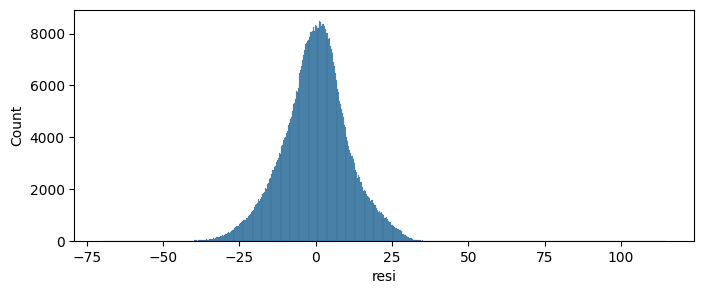

In [19]:
plt.figure(figsize = (8, 3))
sns.histplot(df_train_1['resi'])
plt.show()

In [20]:
df_c0_2, df_prd_0_2 = sc.cache_result(
    'resi_rmse_c0_2', lambda : get_tgt_rmse_list(df_train_1, [['Episode_Length_minutes'] + list(i) for i in combinations(X_val, 0)]), rerun = 0
)
df_c0_2

,X_tgt,RMSE,smooth
0,[Episode_Length_minutes],10.484783,10


In [21]:
df_c1, df_prd_1 = sc.cache_result(
    'resi_rmse_c1', lambda : get_tgt_rmse_list(df_train_1, [list(i) for i in combinations(X_val, 1)]), rerun = 0
)
df_c1

,X_tgt,RMSE,smooth
0,[Host_Popularity_percentage],10.621733,100
1,[Guest_Popularity_percentage],10.639601,100
2,[Number_of_Ads],10.648689,1000
8,[Publication_Time],10.653489,1000
3,[Episode_Sentiment],10.653491,1000
7,[Publication_Day],10.653544,1000
5,[Genre],10.653714,1000
6,[Podcast_Name],10.654786,1000
4,[Episode_Title],10.655814,1000


In [22]:
df_c1_2, df_prd_1_2 = sc.cache_result(
    'resi_rmse_c1_2', lambda : get_tgt_rmse_list(df_train_1, [['Episode_Length_minutes'] + list(i) for i in combinations(X_val, 1)]), rerun = 0
)
df_c1_2

,X_tgt,RMSE,smooth
0,"[Episode_Length_minutes, Host_Popularity_perce...",10.312125,0.1
1,"[Episode_Length_minutes, Guest_Popularity_perc...",10.374132,0.1
2,"[Episode_Length_minutes, Number_of_Ads]",10.414713,10.0
4,"[Episode_Length_minutes, Episode_Title]",10.489752,10.0
3,"[Episode_Length_minutes, Episode_Sentiment]",10.491641,10.0
8,"[Episode_Length_minutes, Publication_Time]",10.501634,10.0
7,"[Episode_Length_minutes, Publication_Day]",10.509294,10.0
6,"[Episode_Length_minutes, Podcast_Name]",10.534436,10.0
5,"[Episode_Length_minutes, Genre]",10.544649,10.0


In [23]:
df_c2, df_prd_2 = sc.cache_result(
    'resi_rmse_c2', lambda : get_tgt_rmse_list(df_train_1, [list(i) for i in combinations(X_val, 2)]), rerun = 0
)
df_c2

,X_tgt,RMSE,smooth
0,"[Host_Popularity_percentage, Guest_Popularity_...",10.504174,1
3,"[Host_Popularity_percentage, Episode_Title]",10.579394,10
10,"[Guest_Popularity_percentage, Episode_Title]",10.589208,10
5,"[Host_Popularity_percentage, Podcast_Name]",10.623273,10
1,"[Host_Popularity_percentage, Number_of_Ads]",10.623279,100
12,"[Guest_Popularity_percentage, Podcast_Name]",10.623465,10
2,"[Host_Popularity_percentage, Episode_Sentiment]",10.627116,100
7,"[Host_Popularity_percentage, Publication_Time]",10.627960,100
6,"[Host_Popularity_percentage, Publication_Day]",10.631175,100
8,"[Guest_Popularity_percentage, Number_of_Ads]",10.635737,100


In [24]:
df_c2_2, df_prd_2_2 = sc.cache_result(
    'resi_rmse_c2_2', lambda : get_tgt_rmse_list(df_train_1, [['Episode_Length_minutes'] + list(i) for i in combinations(X_val, 2)]), rerun = 0
)
df_c2_2

,X_tgt,RMSE,smooth
1,"[Episode_Length_minutes, Host_Popularity_perce...",10.335900,0.10
2,"[Episode_Length_minutes, Host_Popularity_perce...",10.340324,0.10
7,"[Episode_Length_minutes, Host_Popularity_perce...",10.347653,0.10
6,"[Episode_Length_minutes, Host_Popularity_perce...",10.377208,0.01
16,"[Episode_Length_minutes, Number_of_Ads, Episod...",10.386285,1.00
28,"[Episode_Length_minutes, Episode_Title, Public...",10.386661,1.00
8,"[Episode_Length_minutes, Guest_Popularity_perc...",10.397148,0.10
9,"[Episode_Length_minutes, Guest_Popularity_perc...",10.399137,0.10
14,"[Episode_Length_minutes, Guest_Popularity_perc...",10.404589,0.10
29,"[Episode_Length_minutes, Episode_Title, Public...",10.418600,1.00


In [16]:
result_list, tgt_list = list(), list()
for i in ['resi_rmse_c1', 'resi_rmse_c2', 
          'resi_rmse_c0_2', 'resi_rmse_c1_2', 'resi_rmse_c2_2']:
    df_result, df_tgt = sc.read_result(i)
    result_list.append(df_result)
    tgt_list.append(df_tgt)
df_tgt, df_tgt_result = pd.concat(tgt_list, axis=1).rename(columns = lambda x: x + '_r'), pd.concat(result_list)
del result_list, tgt_list

In [17]:
from itertools import combinations
X_val = [
    'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads',
    'Episode_Sentiment', 'Episode_Title', 'Genre', 'Podcast_Name', 'Publication_Day', 'Publication_Time'
]
X_tgts = {
    **{'tgt_{}'.format(j): ['__'.join(i) + '_r' for i in combinations(X_val, j)] for j in range(1, 3)},
    **{'tgt_{}_2'.format(j): ['__'.join(['Episode_Length_minutes'] + list(i)) + '_r' for i in combinations(X_val, j)] for j in range(0, 3)}
}

## LR 3

LR2 와 target과의 잔차를 구해이를 타겟 인코딩하여, 선형회귀모델의 입력으로 사용한 모델제작

In [27]:
hparams = {
    'X_num': X_tgts['tgt_1'] + X_tgts['tgt_2'] + X_tgts['tgt_0_2'] + X_tgts['tgt_1_2'] + X_tgts['tgt_2_2']
}

result = sc.cv_result('LR_3', df_tgt.join(df_train_1[resi]), kf, hparams, config2, 
                      lr_adapter, result_proc = [sgml.lr_learning_result])
np.mean(result['valid_scores'])

np.float64(9.786773349209128)

In [32]:
hparams = {
    'X_num': X_tgts['tgt_1'] + X_tgts['tgt_2'] + X_tgts['tgt_0_2'] + X_tgts['tgt_1_2']
}

result = sgml.cv(df_tgt.join(df_train_1[resi]), kf, hparams, config2, 
                      lr_adapter, result_proc = [sgml.lr_learning_result])
np.mean(result['valid_scores'])

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

np.float64(9.891090580685118)

In [94]:
hparams = {
    'X_num': df_tgt_result.sort_values('RMSE').iloc[:60]['X_tgt'].apply(lambda x: '__'.join(x) + '_r').tolist()
}

result = sgml.cv(df_tgt.join(df_train_1[resi]), kf, hparams, config2, 
                      lr_adapter, result_proc = [sgml.lr_learning_result])
np.mean(result['valid_scores'])

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

np.float64(9.794501221751544)

In [28]:
root_mean_squared_error(
    df_train_1[target], sc.read_prd('LR_2') + sc.read_prd('LR_3')
)

np.float64(9.786777329157738)

In [29]:
(
    (
        (np.mean(sc.read_cv('LR_3a')['valid_scores']) ** 2) * df_train['ELm_na'].sum() + (np.mean(sc.read_cv('LR_3')['valid_scores']) ** 2) * (~df_train['ELm_na']).sum()
    ) / df_train.shape[0]
) ** 0.5

np.float64(12.66693578606717)

In [20]:
(
    (
        (np.mean(sc.read_cv('LR_0')['valid_scores']) ** 2) * df_train['ELm_na'].sum() + (np.mean(sc.read_cv('LR_3')['valid_scores']) ** 2) * (~df_train['ELm_na']).sum()
    ) / df_train.shape[0]
) ** 0.5

np.float64(12.532427558513488)

## LGB1

LR2 와 target과의 잔차를 구해이를 타겟 인코딩한 값을 입력으로한 LGB 모델 구성

In [25]:
hparams = {
    'model_params': {'n_estimators': 700, 'learning_rate': 0.05, 'colsample_bytree': 0.7},
    'X_num': X_tgts['tgt_1'] + X_tgts['tgt_2'] + X_tgts['tgt_0_2'] + X_tgts['tgt_1_2'] + X_tgts['tgt_2_2'],
}

result = sc.cv_result('LGB_1', df_tgt.join(df_train_1[resi]), kf, hparams, {**config2}, lgb_adapter, rerun=0)
np.mean(result['valid_scores'])

Fold:   0%|          | 0/4 [00:00<?, ?it/s]

np.float64(9.699987142612013)

In [26]:
(
    (
        (np.mean(sc.read_cv('LGB_1a')['valid_scores']) ** 2) * df_train['ELm_na'].sum() + (np.mean(sc.read_cv('LGB_1')['valid_scores']) ** 2) * (~df_train['ELm_na']).sum()
    ) / df_train.shape[0]
) ** 0.5

np.float64(12.590982353739836)